# <div style="text-align: center; background-color: #682F2F; font-family:bookantique; color: white; padding: 14px; line-height: 1;border-radius:20px">📊 Comment Classifier</div>

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <h4 style="text-align: left; background-color: #682F2F; font-family:newtimeroman; color: white; padding: 14px; line-height: 1; border-radius:10px"><b>Table of Contents📝</b></h4>
    
   * [1. Business Context](#1)
        - [1.1 Problem ](#1.1)
        - [1.2. Solution](#1.2)
   * [2. Import Important Libraries](#2)
   * [3. Data Exploration](#3)
   * [4. Model Building](#4)
   * [5. Solution](#5)
   * [6. Summery](#6)

<a id="1"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Business Context</div>

### Problem

There are numerous comments that are useless and have the only purpose of promoting other goods or services, regardless of whether they take the shape of product reviews, customer feedback, or some other format. This frequently ruins the experience of other customers and irritates them. Therefore, there needs to be a method through which we may filter these kinds of comments.

### Solution

I have developed a model that can distinguish between genuine comments and advertisements, which improves the consumer experience and eliminates manual filtering work.

<a id="2"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Importing Libraries </div>

In [1]:
# For data analysis and Cleaning of data
import pandas as pd
import numpy as np

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Deep learning
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input,GlobalMaxPool1D,Dropout
from keras.preprocessing.text import one_hot, Tokenizer

# Text preprocessing/analysis
import re
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [2]:
all_estimators = sklearn.utils.all_estimators(type_filter=None)

# styling
%matplotlib inline
sns.set_theme(style="dark")
mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<a id="3"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Data Exploration </div>

### About Dataset:

    Dataset contains 5 columns:
    
        Comment_Id: Randomly generated ID of the comment
        Author: Person who is writing comment
        Date: Exact date and time of the comment
        Content: Content of the comment
        Class: Label of the comment (1: Advertisement , 0: Genuine)


Since these comment ids are generated at random, there is no direct relationship between the comment id and the class label in this case. Therefore, it doesn't actually affect class label, and class label simply depends on the comment's content only. 

So, To determine label of class, we will only use content of the comment.

In [3]:
# Reading data
df = pd.read_csv('data/train.csv')
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
2,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
3,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
4,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [4]:
df.drop(['COMMENT_ID', 'DATE','AUTHOR'], axis=1, inplace=True)

In [5]:
df.shape
df['CLASS'].value_counts()

1    586
0    571
Name: CLASS, dtype: int64

We have a good data, evenly distributed in both classes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1157 non-null   object
 1   CLASS    1157 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.2+ KB


So Null data is not present in the dataset.

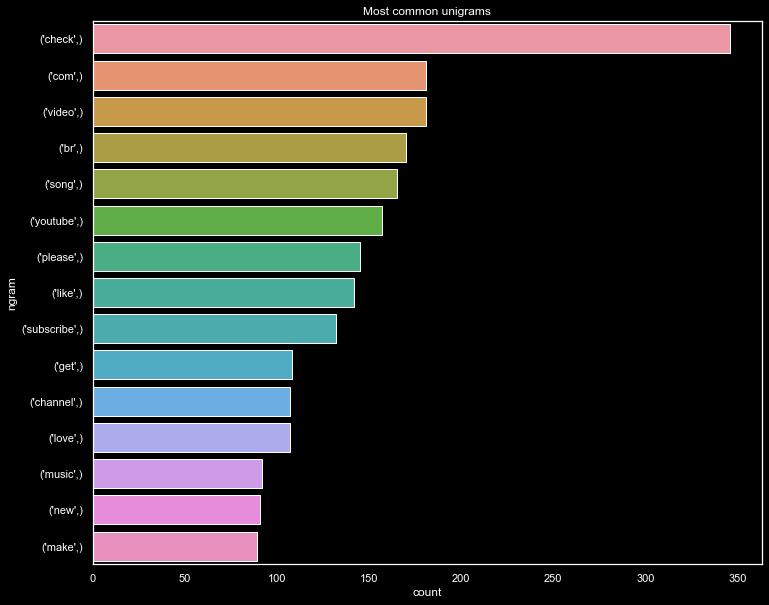

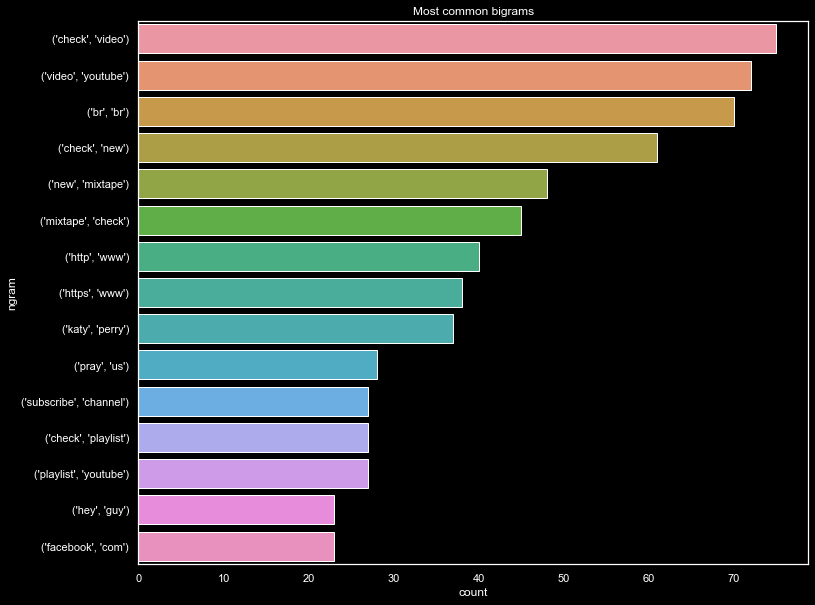

In [7]:
def preprocess_text(text):
    
    """ Preprocess text into normalised tokens.
        Tokenise words into alphabetic tokens
    """
    
    tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    tokens = tokeniser.tokenize(text)
    
    '''
    Why lower case is used because some words contains first letter capital which make it different than lower case letter so to deal with problem lowercase is done.

    lemmatizer is used to convert text into useable formate:
    example:
    -> rocks : rock
    -> corpora : corpus
    -> better : good
    
    Using which we can use it to compare the list to analyse the result
    '''
    
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    stop_words = stopwords.words("english")
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords


def get_frequent_ngram(corpus, ngram, n=15):
    
    """Find most common n n-grams tokens."""
    
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])


# Get frequent ngrams for all 4
for i in range(1,3):
    mapping = {1:"uni", 2:"bi", 3:"tri", 4:"four"}
    plt.figure(figsize=(12,10))
    sns.barplot(x="count", y="ngram", data=get_frequent_ngram(df['CONTENT'], i))
    plt.title(f"Most common {mapping[i]}grams");
    

In [8]:
data= get_frequent_ngram(df['CONTENT'],1)['ngram']
data.head(10)

0        (check,)
1          (com,)
2        (video,)
3           (br,)
4         (song,)
5      (youtube,)
6       (please,)
7         (like,)
8    (subscribe,)
9          (get,)
Name: ngram, dtype: object

<a id="4"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Model Building </div>

### Use most popular algos,
Use some of the most popular ML classification algo to find out the most effective algo.
    
* Multinomial Naive Bayes
* Support Vector classifier
* Random forest classifier
* AdaBoost classifier
* GradientBoost classifier
* Passive Aggressive Classifier
* XGBoost classifier

And we will also use Deep Learning method to find best solution

In [9]:
x = df['CONTENT']
y = df['CLASS']

x_train,x_test,y_train,y_test=train_test_split(df['CONTENT'],y, test_size=0.2, random_state=7)

In [10]:
#DataFlair - Initialize a TfidfVectorizer----- this is used to convert text into vectors using frequency distribution 
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)


#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

tfidf_x = tfidf_vectorizer.fit_transform(x)

In [11]:
models = []
models.append(("mnc",MultinomialNB()))
models.append(("SVMc",SVC()))
models.append(("rfc",RandomForestClassifier()))
models.append(("abc",AdaBoostClassifier()))
models.append(("gbc",GradientBoostingClassifier()))
models.append(("pac",PassiveAggressiveClassifier(max_iter=50)))
models.append(("xgbc",XGBClassifier(eval_metric='mlogloss')))
models.append(("xgrfbc",XGBRFClassifier(eval_metric='mlogloss')))

##### Evaluation and comparison of the models
    also can use scoring = ['accuracy','precision','recall'] 
    where we can use these metrics to analysis 

In [12]:
results = []
names = []

for name, model in models:
	kfold = model_selection.KFold(n_splits=7)
	cv_results = model_selection.cross_val_score(model, tfidf_x, y, cv=kfold, scoring='accuracy')
	results.append(cv_results*100)
	names.append(name)
	msg = "%s: %.2f (%.2f)" % (name, cv_results.mean()*100, cv_results.std()*100)
	print(msg)

mnc: 88.33 (2.97)
SVMc: 90.92 (2.73)
rfc: 92.74 (2.68)
abc: 92.22 (3.69)
gbc: 90.50 (4.50)
pac: 91.01 (1.49)
xgbc: 91.79 (1.82)
xgrfbc: 87.82 (3.84)


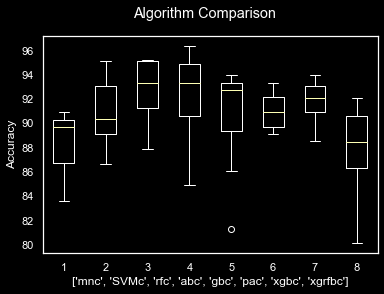

In [13]:
# boxplot of results comparison

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
plt.boxplot(results)
plt.xlabel(names)
plt.ylabel('Accuracy')
plt.show()

#### Artificial Neural Network model

In [14]:
### Artificial Neural Network model
input_dim = tfidf_train.shape[1]  # Number of features

ann_model = Sequential(layers=[
    Dense(units=1024,activation='relu',input_shape=[input_dim]),
    Dense(units=512,activation='tanh'),
    Dense(1,activation='sigmoid')]
)

ann_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(tfidf_train.toarray(), y_train, epochs=10, batch_size=32)

Epoch 1/10
29/29 [==============================] - 1s 21ms/step - loss: 0.4595 - accuracy: 0.8000
Epoch 2/10
29/29 [==============================] - 1s 21ms/step - loss: 0.0545 - accuracy: 0.9805
Epoch 3/10
29/29 [==============================] - 1s 21ms/step - loss: 0.0041 - accuracy: 0.9989
Epoch 4/10
29/29 [==============================] - 1s 22ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 5/10
29/29 [==============================] - 1s 22ms/step - loss: 9.0570e-04 - accuracy: 1.0000
Epoch 6/10
29/29 [==============================] - 1s 21ms/step - loss: 7.1306e-04 - accuracy: 1.0000
Epoch 7/10
29/29 [==============================] - 1s 31ms/step - loss: 5.2104e-04 - accuracy: 1.0000
Epoch 8/10
29/29 [==============================] - 1s 26ms/step - loss: 3.8344e-04 - accuracy: 1.0000
Epoch 9/10
29/29 [==============================] - 1s 21ms/step - loss: 3.1138e-04 - accuracy: 1.0000
Epoch 10/10
29/29 [==============================] - 1s 21ms/step - loss: 2.6967e-04 - ac

In [15]:
ann_model.evaluate(tfidf_train.toarray(), y_train)
ann_model.evaluate(tfidf_test.toarray(), y_test)
print(ann_model.summary())

8/8 [==============================] - 0s 5ms/step - loss: 0.3415 - accuracy: 0.9095
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2622464   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,147,777
Trainable params: 3,147,777
Non-trainable params: 0
_________________________________________________________________
None


<a id="5"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Solution</div>

#### "Random forest classifier" work best
##### Results:
    From the Boxlpot and ANN
    Random forest classifier have avg accuracy of 93.26
    ANN have accuracy of 91.38
So selecting RF for production

Use Optuna to find optimal model hyperparameter

In [19]:
import optuna

def objective(trial):       # define an objective to test different hyperparameter
      
      n_estimators = trial.suggest_int('n_estimators', 2, 30)
      max_depth = int(trial.suggest_int('max_depth', 1, 60))
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(clf, tfidf_x, y, n_jobs=-1, cv=5).mean()


study = optuna.create_study(direction='maximize')     # direction defines weather to find max or min values for hyperparameter
study.optimize(objective, n_trials=100)              # number of trials is iterations done to find best hyperparameter

# best trials will gives best hyperparameter
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2022-10-09 01:33:30,533] A new study created in memory with name: no-name-f62513c8-0d0f-43bd-b65d-81c934f2cf6a
[I 2022-10-09 01:33:30,593] Trial 0 finished with value: 0.8478989401403194 and parameters: {'n_estimators': 22, 'max_depth': 2}. Best is trial 0 with value: 0.8478989401403194.
[I 2022-10-09 01:33:30,652] Trial 1 finished with value: 0.7969510374682788 and parameters: {'n_estimators': 8, 'max_depth': 11}. Best is trial 0 with value: 0.8478989401403194.
[I 2022-10-09 01:33:30,749] Trial 2 finished with value: 0.8755523212419764 and parameters: {'n_estimators': 16, 'max_depth': 15}. Best is trial 2 with value: 0.8755523212419764.
[I 2022-10-09 01:33:30,912] Trial 3 finished with value: 0.9040677713091506 and parameters: {'n_estimators': 25, 'max_depth': 33}. Best is trial 3 with value: 0.9040677713091506.
[I 2022-10-09 01:33:31,015] Trial 4 finished with value: 0.9075384385729214 and parameters: {'n_estimators': 15, 'max_depth': 48}. Best is trial 4 with value: 0.90753843857

Accuracy: 0.9248022092849679
Best hyperparameters: {'n_estimators': 30, 'max_depth': 59}


Use these parameters to build a model using whole dataset

In [21]:
rfcs = RandomForestClassifier(n_estimators= 30, max_depth=59)

In [22]:
rfcs.fit(tfidf_x, y)

RandomForestClassifier(max_depth=59, n_estimators=30)

In [23]:
test_df = pd.read_csv('data/test.csv')
X_Test = test_df['CONTENT']
tx = tfidf_vectorizer.transform(X_Test)

# Predictions of the model
y_pred=rfcs.predict(tx)

To submit the output:

    submisstion = pd.DataFrame()
    submisstion['ID'] = test_df['ID']
    submisstion['CLASS'] = y_pred
    submisstion.to_csv('ans1.csv', index=False)

<a id="5"></a>
# <div style="text-align: center; background-color: #682F2F; font-family:newtimeroman;font-size:15px color: white; padding: 14px; line-height:0.5;border-radius:20px">Summary</div>